In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime


In [3]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/polyp"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/polyp/03_model_weights/resnet"
MODEL_NAME = "20240325_1446"

In [4]:
import yaml

# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [5]:
config

{'mean_RGB_values_path': None,
 'ml_data_dir': 'data/polyp/02_prepared_data',
 'model': {'batch_size': 40,
  'embedding_size': 1024,
  'epochs': 100,
  'lr': 0.0001,
  'model_input': 'image_and_probas',
  'num_workers': 8,
  'patience': 20,
  'resnet': 'resnet50',
  'target_recall': 0.9},
 'output_dir': 'data/polyp/03_model_weights/resnet',
 'polyp': True,
 'probas_dir': 'data/polyp/04_predictions'}

In [20]:
IMG_SIZE = 500
EMBEDDING_SIZE = config["model"]["embedding_size"]

In [21]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")


In [22]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(tqdm(zip(sorted(os.listdir(pred_probas_dir)),
                                                                       sorted(os.listdir(res_emb_dir)),
                                                                       sorted(os.listdir(labels_dir))))):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        # print(pred_proba.shape)
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [23]:
cal_pred_probas, cal_res_emb, cal_labels = load_data(DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS)


252it [00:00, 418.90it/s]


In [24]:
test_pred_probas, test_res_emb, test_labels = load_data(DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS)

546it [00:01, 438.93it/s]


In [25]:
index_not_empy = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
cal_labels = cal_labels[index_not_empy]
cal_res_emb = cal_res_emb[index_not_empy]
cal_pred_probas = cal_pred_probas[index_not_empy]

In [26]:
cal_labels.shape, cal_res_emb.shape, cal_pred_probas.shape

((252, 500, 500), (252, 1024), (252, 500, 500))

In [27]:
cal_labels.max(), cal_pred_probas.max()

(1.0, 0.9997115135192871)

In [28]:
ALPHA = .1
N = len(cal_labels)
N


252

In [29]:
minimization_methods = ["BFGS", "Newton-CG", "L-BFGS-B", "TNC", "SLSQP", "dogleg", "trust-ncg", "trust-krylov", "trust-exact", "trust-constr"]

for method in minimization_methods:
    try:
        result = minimize(
            J, np.random.uniform(0, 1, EMBEDDING_SIZE),
            method=method,
            args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, N), jac=J_prime,
            options={"disp": False, "maxiter": 1000}, tol=1e-10
        )
        
        ths = (test_res_emb @ result.x).reshape(-1, 1, 1)
        y_pred_test_th = (test_pred_probas >= ths).astype(int)
        recall_test = (y_pred_test_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
        print(f"=============== {method} ===============")
        print(result)
        print(f"Recall test: {np.nanmean(recall_test)}")
    except Exception as e:
        print(f"=============== {method} ===============")
        print(e)
        print("")

KeyboardInterrupt: 

In [15]:
result = minimize(
    J, np.random.uniform(0, 1, EMBEDDING_SIZE),
    method="SLSQP",
    args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, N), jac=J_prime,
    options={"disp": True, "maxiter": 10000}
    
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.64367380121399
            Iterations: 133
            Function evaluations: 142
            Gradient evaluations: 133


In [16]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -9.64367380121399
       x: [ 6.990e-01  2.089e-01 ...  8.124e-01  1.911e-01]
     nit: 133
     jac: [ 3.564e-04  1.347e-04 ...  6.644e-06  1.233e-04]
    nfev: 142
    njev: 133

In [17]:
ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
ths = (test_res_emb @ result.x).reshape(-1, 1, 1)

In [18]:
test_res_emb.shape

(546, 1024)

In [19]:
y_pred_test_th = (test_pred_probas >= ths).astype(int)
recall_test = (y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1)

/tmp/ipykernel_1183597/1774683259.py:2: RuntimeWarning: invalid value encountered in divide
  recall_test = (y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1)


In [20]:
np.nanmean(recall_test), 1 - ALPHA + 1/N

(0.7929953933487126, 0.903968253968254)

In [21]:
precision_test = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
np.mean(precision_test)

/tmp/ipykernel_1183597/3317103724.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)


0.7563945374969422

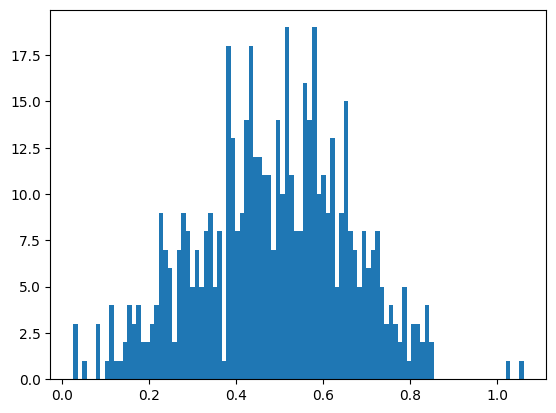

In [22]:
plt.hist(ths[:, 0, 0], bins=100)
plt.show()

(array([ 77.,  15.,   5.,   7.,  11.,   5.,  14.,  27.,  57., 328.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

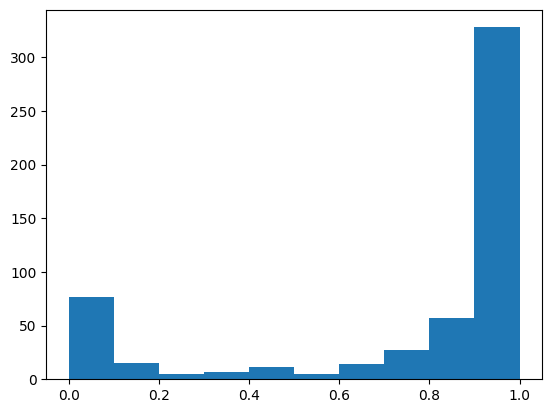

In [23]:
plt.hist(precision_test)